In [3]:
%pip install -q mediapipe


Note: you may need to restart the kernel to use updated packages.


In [19]:
#@markdown To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

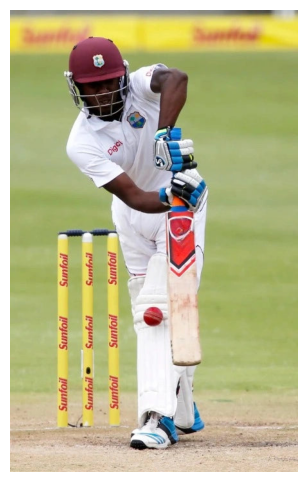

In [20]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/home/samuda/samuda/Samuda Projects/DL/Cricket-Biomechanics-MLOPs/notebooks/wi.jpeg")
# OpenCV reads BGR; convert to RGB for correct colors
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,6))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()


I0000 00:00:1763800057.291551   82828 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763800057.294262   87895 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (ADL GT2)
W0000 00:00:1763800057.374257   87897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763800057.416369   87905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


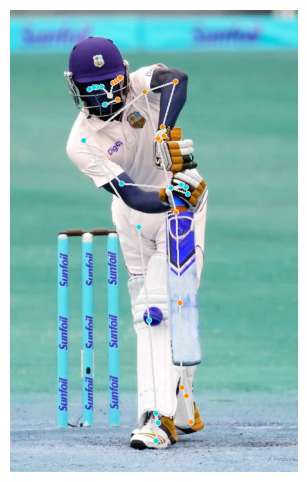

In [21]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt

# Load model
base_options = python.BaseOptions(
    model_asset_path="/home/samuda/samuda/Samuda Projects/DL/Cricket-Biomechanics-MLOPs/notebooks/pose_landmarker_lite.task"
)
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True,
)
detector = vision.PoseLandmarker.create_from_options(options)

# Read image
image = mp.Image.create_from_file("/home/samuda/samuda/Samuda Projects/DL/Cricket-Biomechanics-MLOPs/notebooks/wi.jpeg")

# Detect
detection_result = detector.detect(image)

# Draw (adapt your draw_landmarks_on_image or use mediapipe drawing utils)
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)

# Show inline (convert BGR/MP format to RGB if needed)
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


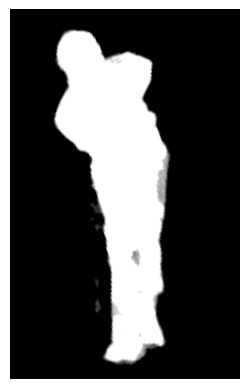

In [24]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_mask = detection_result.segmentation_masks[0].numpy_view()  # HxW float in [0,1]
visualized_mask = (np.repeat(segmentation_mask[:, :, None], 3, axis=2) * 255).astype(np.uint8)

plt.imshow(visualized_mask, cmap="gray")
plt.axis("off")
plt.show()


In [1]:
# !pip install mediapipe opencv-python matplotlib numpy

import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions

In [2]:
def get_center_of_mass(landmarks):
    """
    Calculates the midpoint between the Left Hip (23) and Right Hip (24).
    """
    # indices: 23=Left Hip, 24=Right Hip
    left_hip = landmarks[23]
    right_hip = landmarks[24]
    
    # Calculate average X and Y
    com_x = (left_hip.x + right_hip.x) / 2
    com_y = (left_hip.y + right_hip.y) / 2
    
    return com_x, com_y

def calculate_weight_transfer(landmarks):
    """
    Calculates how much weight is on the front foot.
    Returns a percentage (0-100).
    """
    # Indices: 27=Left Ankle, 28=Right Ankle
    left_ankle = landmarks[27]
    right_ankle = landmarks[28]
    
    # Get CoM X coordinate
    com_x, _ = get_center_of_mass(landmarks)
    
    # 1. Determine Stance Width (Distance between feet)
    stance_width = abs(left_ankle.x - right_ankle.x)
    
    # Safety check for zero division
    if stance_width < 0.01:
        return 50.0
        
    # 2. Identify Back Foot (Assuming the foot with smaller X is back)
    # Note: This logic changes if the batter is left-handed or camera is flipped.
    # Assuming Standard Broadcast View: Bowler is on Left, Batter on Right.
    back_foot_x = min(left_ankle.x, right_ankle.x)
    
    # 3. Calculate Distance of CoM from Back Foot
    dist_from_back = com_x - back_foot_x
    
    # 4. Calculate Ratio
    percentage = (dist_from_back / stance_width) * 100
    
    # Clip results to keep them realistic
    return np.clip(percentage, 0, 100)

In [3]:
def draw_analysis_overlay(image, detection_result):
    # Work on a copy of the image
    annotated_image = np.copy(image)
    h, w, _ = annotated_image.shape
    
    # If no person detected, return original image
    if not detection_result.pose_landmarks:
        return annotated_image

    # --- 1. Draw Skeleton ---
    pose_landmarks_list = detection_result.pose_landmarks
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=l.x, y=l.y, z=l.z) for l in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style())

    # --- 2. Calculate Physics ---
    landmarks = pose_landmarks_list[0] # Get first person
    
    # Get Forward Percentage (from previous logic)
    forward_pct = calculate_weight_transfer(landmarks)
    
    # Calculate Back Percentage
    back_pct = 100 - forward_pct
    
    # Get CoM coordinates for the dot
    com_x, com_y = get_center_of_mass(landmarks)

    # --- 3. Draw Center of Mass (Yellow Dot) ---
    cx, cy = int(com_x * w), int(com_y * h)
    cv2.circle(annotated_image, (cx, cy), 15, (0, 255, 255), -1)
    cv2.circle(annotated_image, (cx, cy), 18, (0, 0, 0), 2) # Black border

    # --- 4. Draw The "Pro" UI Bar ---
    # Configuration
    bar_x = 50
    bar_y = h - 100
    bar_w = 400
    bar_h = 40
    
    # A. Draw the "Back" portion (RED) - Left Side
    # The width is proportional to the back percentage
    split_point = int((back_pct / 100) * bar_w)
    
    # Draw Red Rectangle (Back Weight)
    cv2.rectangle(annotated_image, (bar_x, bar_y), (bar_x + split_point, bar_y + bar_h), (0, 0, 255), -1)
    
    # Draw Blue Rectangle (Forward Weight) - Right Side
    cv2.rectangle(annotated_image, (bar_x + split_point, bar_y), (bar_x + bar_w, bar_y + bar_h), (255, 150, 0), -1)
    
    # Draw Border around the whole bar
    cv2.rectangle(annotated_image, (bar_x, bar_y), (bar_x + bar_w, bar_y + bar_h), (255, 255, 255), 3)
    
    # --- 5. Add Text Labels ---
    
    # "Weight Transfer" Title
    cv2.putText(annotated_image, "WEIGHT TRANSFER", (bar_x, bar_y - 15), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    # Back Percentage (Left side)
    cv2.putText(annotated_image, f"{int(back_pct)}% BACK", (bar_x, bar_y + bar_h + 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2) # Red Text
                
    # Forward Percentage (Right side)
    # Calculate text width to align it to the right
    text_forward = f"FORWARD {int(forward_pct)}%"
    (fw_w, _), _ = cv2.getTextSize(text_forward, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
    cv2.putText(annotated_image, text_forward, (bar_x + bar_w - fw_w, bar_y + bar_h + 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 150, 0), 2) # Blue Text
    
    return annotated_image

I0000 00:00:1763822387.842994  217670 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763822387.853801  217825 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (ADL GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1763822388.080394  217826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763822388.389685  217832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763822388.720913  217835 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


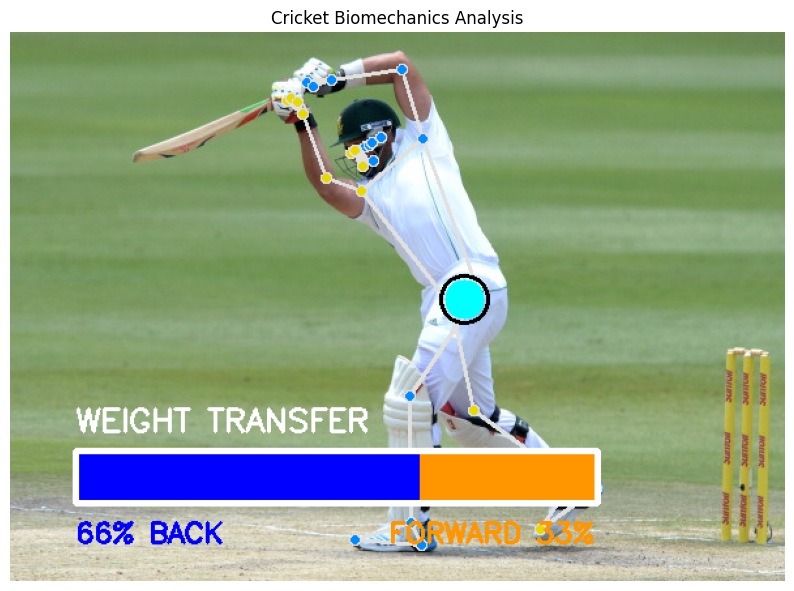

In [4]:
# --- CONFIGURATION ---
# MODEL_PATH = "/home/samuda/samuda/Samuda Projects/DL/Cricket-Biomechanics-MLOPs/notebooks/pose_landmarker_lite.task"
MODEL_PATH = "/home/samuda/samuda/Samuda Projects/DL/Cricket-Biomechanics-MLOPs/notebooks/pose_landmarker_heavy.task"
IMAGE_PATH = "/home/samuda/samuda/Samuda Projects/DL/Cricket-Biomechanics-MLOPs/notebooks/jk.jpg"
# ---------------------

# 1. Setup Model
base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False # We don't need masks for this
)
detector = vision.PoseLandmarker.create_from_options(options)

# 2. Load Image using MediaPipe
mp_image = mp.Image.create_from_file(IMAGE_PATH)

# 3. Detect
detection_result = detector.detect(mp_image)

# 4. Visualize (Using our custom function from Cell 3)
# Note: mp_image.numpy_view() gives us the image array
final_image = draw_analysis_overlay(mp_image.numpy_view(), detection_result)

# 5. Display
plt.figure(figsize=(10,10))
plt.imshow(final_image) # Matplotlib expects RGB, MediaPipe gives RGB
plt.axis("off")
plt.title("Cricket Biomechanics Analysis")
plt.show()

In [6]:
import cv2
import mediapipe as mp
import numpy as np

# --- CONFIGURATION ---
INPUT_VIDEO_PATH = "/home/samuda/samuda/Samuda Projects/DL/Cricket-Biomechanics-MLOPs/notebooks/vk1.mp4" # Change this
OUTPUT_VIDEO_PATH = "processed_cricket_analysis.mp4"
# ---------------------

def process_video(input_path, output_path):
    print(f"Processing video: {input_path}")
    
    # 1. Setup Video Capture (Read)
    cap = cv2.VideoCapture(input_path)
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # 2. Setup Video Writer (Save)
    # 'mp4v' is a standard codec for .mp4 files
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break # End of video
            
        frame_count += 1
        if frame_count % 10 == 0:
            print(f"Processing frame {frame_count}/{total_frames}...")

        # 3. Convert Color (OpenCV uses BGR, MediaPipe needs RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        
        # 4. Run Detection
        detection_result = detector.detect(mp_image)
        
        # 5. Draw Overlay (Using our function from Cell 3)
        # The function returns an RGB image
        annotated_frame_rgb = draw_analysis_overlay(frame_rgb, detection_result)
        
        # 6. Convert back to BGR for saving
        annotated_frame_bgr = cv2.cvtColor(annotated_frame_rgb, cv2.COLOR_RGB2BGR)
        
        # 7. Write Frame
        out.write(annotated_frame_bgr)

    # Cleanup
    cap.release()
    out.release()
    print(f"Done! Saved to: {output_path}")

# Run the function
process_video(INPUT_VIDEO_PATH, OUTPUT_VIDEO_PATH)

Processing video: /home/samuda/samuda/Samuda Projects/DL/Cricket-Biomechanics-MLOPs/notebooks/vk1.mp4
Processing frame 10/800...
Processing frame 20/800...
Processing frame 30/800...
Processing frame 40/800...
Processing frame 50/800...
Processing frame 60/800...
Processing frame 70/800...
Processing frame 80/800...
Processing frame 90/800...
Processing frame 100/800...
Processing frame 110/800...
Processing frame 120/800...
Processing frame 130/800...
Processing frame 140/800...
Processing frame 150/800...
Processing frame 160/800...
Processing frame 170/800...
Processing frame 180/800...
Processing frame 190/800...
Processing frame 200/800...
Processing frame 210/800...
Processing frame 220/800...
Processing frame 230/800...
Processing frame 240/800...
Processing frame 250/800...
Processing frame 260/800...
Processing frame 270/800...
Processing frame 280/800...
Processing frame 290/800...
Processing frame 300/800...
Processing frame 310/800...
Processing frame 320/800...
Processing 